# Carbonates loss plots and table 

## Plotting 1 DTG graph

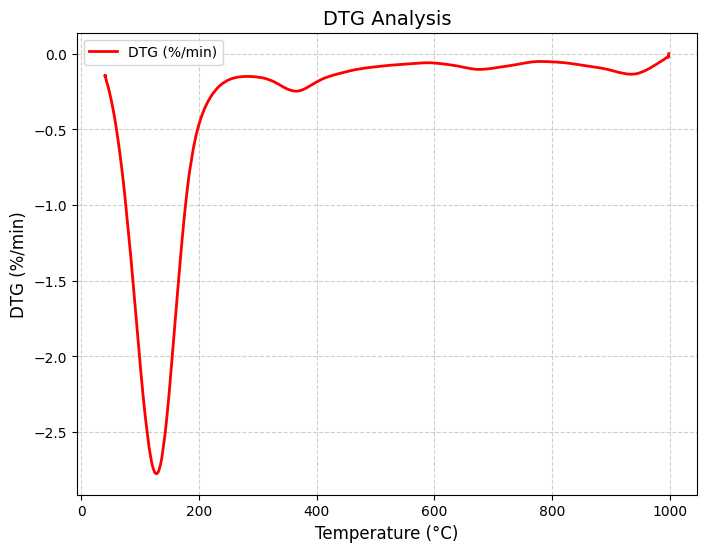

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File path (update if needed)
dtg_file_path = "DG_ExpDat_A8%DC1; 17-1-2025-2.csv"  # Ensure correct path

# Read CSV file, skipping metadata rows
df_dtg = pd.read_csv(dtg_file_path, encoding="ISO-8859-1", skiprows=30, header=0)

# Rename columns (modify based on actual structure)
df_dtg.columns = ["Temperature", "Time", "DSC", "Mass%", "GasFlow1", "GasFlow2", "GasFlow3", "DTG", "Sensitivity"]

# Convert relevant columns to numeric
df_dtg["Temperature"] = pd.to_numeric(df_dtg["Temperature"], errors="coerce")
df_dtg["DTG"] = pd.to_numeric(df_dtg["DTG"], errors="coerce")

# Drop NaN values
df_dtg = df_dtg.dropna()

# Plot DTG (%/min) vs. Temperature (°C)
plt.figure(figsize=(8,6))
plt.plot(df_dtg["Temperature"], df_dtg["DTG"], 'r-', linewidth=2, label="DTG (%/min)")
plt.xlabel("Temperature (°C)", fontsize=12)
plt.ylabel("DTG (%/min)", fontsize=12)
plt.title("DTG Analysis", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## general code to plot TGA and DTG and calculate mass % lost between two chosen temperature points

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_tga_dtg_zone(
    tga_file: str,
    dtg_file: str,
    x_start: float,
    x_end: float,
    skiprows: int = 30
) -> float:
    """
    Loads TGA and DTG CSV files, plots them together, shades a temperature window
    between x_start and x_end, shades the corresponding TGA weight-difference
    region on the y-axis, annotates ΔWeight, and returns the weight difference.

    Parameters
    ----------
    tga_file : str
        Path to the TGA CSV (no header, skiprows rows of metadata).
    dtg_file : str
        Path to the DTG CSV (header=0, skiprows rows of metadata).
    x_start : float
        Lower temperature bound of the shaded zone (°C).
    x_end : float
        Upper temperature bound of the shaded zone (°C).
    skiprows : int, optional
        Number of rows to skip at the top of each CSV, by default 30

    Returns
    -------
    float
        The difference in TGA weight (%) between x_start and x_end.
    """
    # --- 1. LOAD & CLEAN TGA DATA ---
    df_tga = pd.read_csv(
        tga_file,
        encoding="ISO-8859-1",
        skiprows=skiprows,
        header=None
    )
    ncols = df_tga.shape[1]
    cols = ["Temperature", "Time", "Value", "Weight%"] + \
           [f"Other{i}" for i in range(1, ncols - 3)]
    df_tga.columns = cols
    df_tga = df_tga[["Temperature", "Weight%"]].dropna()
    df_tga["Temperature"] = pd.to_numeric(df_tga["Temperature"], errors="coerce")
    df_tga["Weight%"]     = pd.to_numeric(df_tga["Weight%"],     errors="coerce")

    # --- 2. LOAD & CLEAN DTG DATA ---
    df_dtg = pd.read_csv(
        dtg_file,
        encoding="ISO-8859-1",
        skiprows=skiprows,
        header=0
    )
    df_dtg.columns = [
        "Temperature", "Time", "DSC", "Mass%",
        "GasFlow1", "GasFlow2", "GasFlow3",
        "DTG", "Sensitivity"
    ]
    df_dtg = df_dtg[["Temperature", "DTG"]].dropna()
    df_dtg["Temperature"] = pd.to_numeric(df_dtg["Temperature"], errors="coerce")
    df_dtg["DTG"]         = pd.to_numeric(df_dtg["DTG"],         errors="coerce")

    # --- 3. INTERPOLATE TGA WEIGHT AT x_start & x_end ---
    w_start     = np.interp(x_start, df_tga["Temperature"], df_tga["Weight%"])
    w_end       = np.interp(x_end,   df_tga["Temperature"], df_tga["Weight%"])
    weight_diff = w_start - w_end

    # --- 4. PLOT EVERYTHING ---
    fig, ax1 = plt.subplots(figsize=(8, 6))

    # TGA curve
    ax1.plot(
        df_tga["Temperature"],
        df_tga["Weight%"],
        color="tab:blue",
        linewidth=2,
        label="TGA (Weight%)"
    )
    ax1.set_xlabel("Temperature (°C)")
    ax1.set_ylabel("Weight (%)", color="tab:blue")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # vertical temperature window
    ax1.axvspan(x_start, x_end, color="gray", alpha=0.3)

    # horizontal weight region
    ymin, ymax = sorted([w_start, w_end])
    ax1.axhspan(ymin, ymax, color="tab:blue", alpha=0.2)

    # annotate ΔWeight
    xlim = ax1.get_xlim()
    x_annot = xlim[0] + 0.02 * (xlim[1] - xlim[0])
    y_mid = (w_start + w_end) / 2
    ax1.text(
        x_annot, y_mid,
        f"ΔWeight = {weight_diff:.2f}%",
        color="tab:blue",
        fontsize=11,
        va="center",
        bbox=dict(facecolor="white", edgecolor="tab:blue", alpha=0.5, boxstyle="round")
    )

    # DTG curve on twin axis
    ax2 = ax1.twinx()
    ax2.plot(
        df_dtg["Temperature"],
        df_dtg["DTG"],
        color="tab:red",
        linestyle="--",
        linewidth=2,
        label="DTG (%/min)"
    )
    ax2.set_ylabel("DTG (%/min)", color="tab:red")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # legend
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1+h2, l1+l2, loc="upper right")

    plt.title("Overlaid TGA & DTG with Highlighted Zones")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # return the weight difference
    return weight_diff

In [50]:
# ─── Cell 2: interactive controls ───────────────────────────────────────────────
from ipywidgets import interact, FloatText, fixed

# adjust these two strings if your files live elsewhere
TGA_FILE = "TG_ExpDat_A8%DC1; 17-1-2025-2.csv"
DTG_FILE = "DG_ExpDat_A8%DC1; 17-1-2025-2.csv"

@interact(
    x_start = FloatText(350.0, description="Start (°C)"),
    x_end   = FloatText(450.0, description="End (°C)")
)
def _update(x_start, x_end):
    dW = plot_tga_dtg_zone(
        tga_file=TGA_FILE,
        dtg_file=DTG_FILE,
        x_start=x_start,
        x_end=x_end,
        skiprows=30
    )
    print(f"Weight loss between {x_start:.1f}°C and {x_end:.1f}°C: {dW:.2f}%");


interactive(children=(FloatText(value=350.0, description='Start (°C)'), FloatText(value=450.0, description='En…

# Before and after carbonation TGA - DTG plots per mix design

## Mix design <span style="background-color:rgb(70, 169, 211); color: #000;"> B30S70 </span>: 28 days after casting and curing  (not the right data)

In [19]:
#plot_tga_dtg_zone('TG_ExpDat_A8%DC14; 30-1-2025-2.csv','DG_ExpDat_A8%DC14; 30-1-2025-2.csv',350,600)

## Mix design <span style="background-color:rgb(70, 169, 211); color: #000;"> B30S70 </span>: 28 days after casting and curing + 28 of carbonation (not the right data)

In [21]:
# plot_tga_dtg_zone('TG_ExpDat_A8%DC14; 30-1-2025-2.csv','DG_ExpDat_A8%DC14; 30-1-2025-2.csv',350,600)

## Mix design <span style="background-color: #FFA500; color: #000;"> B50S50 </span>: 28 days after casting and curing + 28 of (not the right data)

In [ ]:
# plot_tga_dtg_zone('TG_ExpDat_A8%DC14; 30-1-2025-2.csv','DG_ExpDat_A8%DC14; 30-1-2025-2.csv',350,600)

## Mix design <span style="background-color: #FFA500; color: #000;"> B50S50 </span>: 28 days after casting and curing + 28 of carbonation (not the right data)

In [ ]:
# plot_tga_dtg_zone('TG_ExpDat_A8%DC14; 30-1-2025-2.csv','DG_ExpDat_A8%DC14; 30-1-2025-2.csv',350,600)

## Mix design <span style="background-color:rgb(28, 128, 43); color: #000;"> OPC7% </span>: 28 days after casting and curing

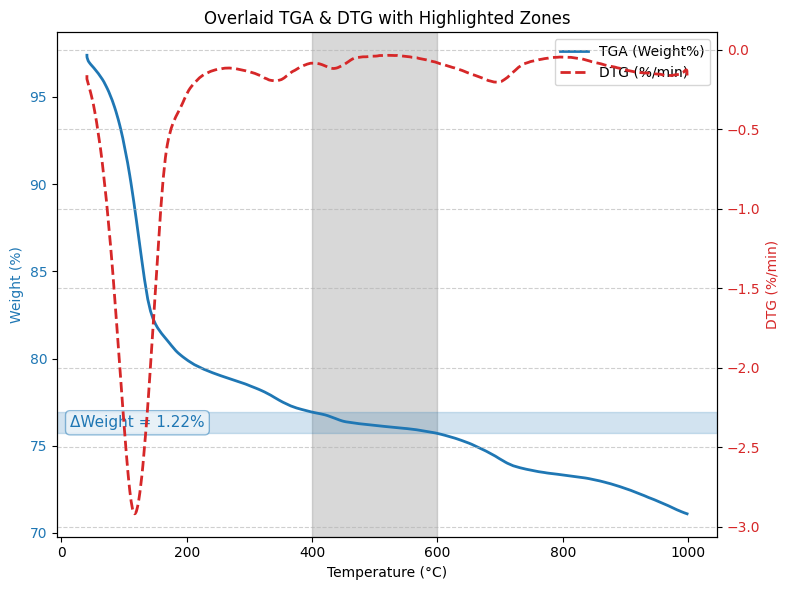

1.223118418590559

In [25]:
plot_tga_dtg_zone('TG_ExpDat_OPC7%D28; 13-1-2025-2.csv','DG_ExpDat_OPC7%D28; 13-1-2025-2.csv',400,600)

## Mix design <span style="background-color:rgb(28, 128, 43); color: #000;"> OPC7% </span>: 28 days after casting and curing + 28 of carbonation (data error)

In [ ]:
# plot_tga_dtg_zone('TG_ExpDat_A8%DC14; 30-1-2025-2.csv','DG_ExpDat_A8%DC14; 30-1-2025-2.csv',350,600)

## Mix design <span style="background-color: #AFDEF1; color: #000;"> OPC9% </span>: 28 days after casting and curing

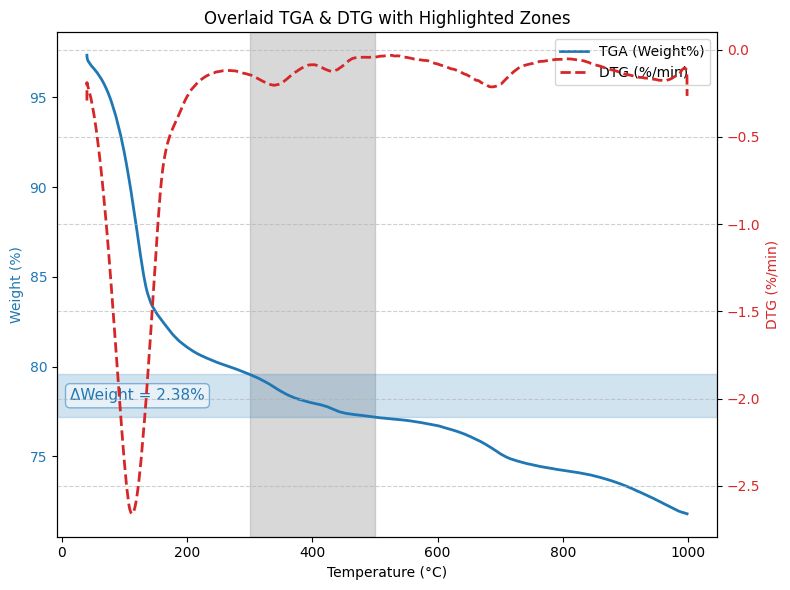

2.3812051634385085

In [33]:
plot_tga_dtg_zone('TG_ExpDat_OPC9%D28; 13-1-2025-2.csv','DG_ExpDat_OPC9%D28; 13-1-2025-2.csv',300,500)

## Mix design <span style="background-color: #AFDEF1; color: #000;"> OPC9% </span>: 28 days after casting and curing + 28 days of carbonation

In [37]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_OPC9%DC28; 13-2-2025-2.csv"
DTG_PATH = "DG_ExpDat_OPC9%DC28; 13-2-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color: #DFB8DB; color: #000;"> MgO5% </span>: 28 days after casting and curing 

In [38]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_MgO5%D28; 16-1-2025-2.csv"
DTG_PATH = "DG_ExpDat_MgO5%D28; 16-1-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color: #DFB8DB; color: #000;"> MgO5% </span>: 28 days after casting and curing + 28 days of carbonation

In [39]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_MgO5%DC28; 14-1-2025-2.csv"
DTG_PATH = "DG_ExpDat_MgO5%DC28; 14-1-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(117, 211, 80); color: #000;"> A8% </span>: 28 days after casting and curing 

In [40]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_A8%D28; 16-1-2025-2.csv"
DTG_PATH = "DG_ExpDat_A8%D28; 16-1-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(117, 211, 80); color: #000;"> A8% </span>: 28 days after casting and curing + 28 days of carbonation

In [42]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_A8%DC28; 14-2-2025-2.csv"
DTG_PATH = "DG_ExpDat_A8%DC28; 14-2-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(237, 8, 8); color: #000;"> CEM I </span>: 28 days after casting and curing 

In [43]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_CEM_I_D28; 16-1-2025-2.csv"
DTG_PATH = "DG_ExpDat_CEM_I_D28; 16-1-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(237, 8, 8); color: #000;"> CEM I </span>: 28 days after casting and curing + 28 days of carbonation

In [44]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_CEM_I_DC28; 14-2-2025-2.csv"
DTG_PATH = "DG_ExpDat_CEM_I_DC28; 14-2-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(101, 39, 6); color: #000;"> CEM III/B </span>: 28 days after casting and curing 

In [46]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_CEM_III_D28; 16-1-2025-2.csv"
DTG_PATH = "DG_ExpDat_CEM_III_D28; 16-1-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>

## Mix design <span style="background-color:rgb(101, 39, 6); color: #000;"> CEM III/B </span>: 28 days after casting and curing + 28 days of carbonation

In [47]:
from ipywidgets import interact, fixed, FloatText

# assume your function is already defined in the namespace:
# def plot_tga_dtg_zone(tga_file, dtg_file, x_start, x_end, skiprows=30): ...

TGA_PATH = "TG_ExpDat_CEM_III_DC28; 14-2-2025-2.csv"
DTG_PATH = "DG_ExpDat_CEM_III_DC28; 14-2-2025-2.csv"

interact(
    plot_tga_dtg_zone,
    tga_file = fixed(TGA_PATH),
    dtg_file = fixed(DTG_PATH),
    x_start  = FloatText(400, description="Start (°C)"),
    x_end    = FloatText(800, description="End (°C)"),
    skiprows = fixed(30)
)


interactive(children=(FloatText(value=400.0, description='Start (°C)'), FloatText(value=800.0, description='En…

<function __main__.plot_tga_dtg_zone(tga_file: str, dtg_file: str, x_start: float, x_end: float, skiprows: int = 30) -> float>